In [1]:
import tensorflow as tf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
from scipy.integrate import solve_ivp, odeint, complex_ode,ode
from scipy import linalg

import pandas as pd

import time

2023-09-12 02:35:09.509986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 02:35:09.627732: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-12 02:35:09.658618: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-12 02:35:10.196701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
tf.__version__
if tf.test.gpu_device_name() != '/device:GPU:0':
    print('WARNING: GPU device not found.')
else:
    print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


2023-09-12 02:35:11.264740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-12 02:35:11.339586: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 02:35:11.363945: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 02:35:11.364066: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so ret

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
        gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5120)])
    except RuntimeError as e:
        print(e)

2023-09-12 02:35:11.814484: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 02:35:11.815287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 02:35:11.815794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [4]:
class MyDense(tf.keras.layers.Layer):
    '''
    Inputs:
    
    units : number of neurons
    initialization = 0,1
           if activations are:
           init =0(He): ReLU, Leaky ReLU, ELU, GELU, Swish, Mish
           init =1(Xavier_Glorot): None, tanh, sigmoid, softmax 
           
    activation: activation to be use either string or callable
    
    
    Output:
            returns activation(wx+b) with appropriate initialization
    
    '''
    def __init__(self, units = 20, initialization=None, activation = None): #None = gives basic activation
        super(MyDense, self).__init__()
        self.units = units   
        self.init = initialization
        
        if activation == 'mish':
            self.activation = tf.keras.activations.get(self.mish_activation)
        else:
            self.activation = tf.keras.activations.get(activation)
       
    @tf.function
    def mish_activation(self, x):
        print(f'called_mish')
    #     mish(x) = xtanh(softsplus(x))  it needs  He initialization
        return x*tf.math.tanh(tf.nn.softplus(x))       
    
    
# We get them from the shape of w= shape
# shape[0] : number of inputs to the neuron
# shape[1] : number of output from the neuron
#     @tf.function(reduce_retracing=True)
    def Xavier_Glorot_initializer(self,shape, dtype=tf.float32):
        '''
        Xavier Glorot: initialization must be used for the following activations:
        None, tanh, sigmoid, softmax

       input: 
            shape = [number of columns, units]

       output:
               samples normal distribution of mean = 0 stddev = sqrt(2./inputs_shape+units)
        '''
        print('Initial weight with  Xavier Glorot ')
        
        shape_to_float = tf.cast(shape, dtype=tf.float32)
        fanin = shape_to_float[0]
        fanout = shape_to_float[1]
        stddev = tf.sqrt(2. /(fanin+fanout)  )
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)
    
#     @tf.function(reduce_retracing=True) 
    def He_initializer(self,shape,dtype = tf.float32):
        '''
        input: 
                shape = [number of columns, units]

        He (aka He normal)initialization must be used for the following activations:
        ReLU, Leaky ReLU, ELU, GELU, Swish, Mish

        He initialization:
        random normal with variance and mean of 2/fanin = 2/no. of inputs = 2/inputs
        '''
        shape_to_float = tf.cast(shape, dtype=tf.float32)
#         print(f'INIT shape = {shape}, dtype = {shape.dtype}')
#         fanin = tf.constant(shape[0], dtype = tf.float32)
        fanin = shape_to_float[0]
#         print(f'fanin = {fanin}')
        stddev = tf.sqrt(2. /fanin)
#         print(f'stddev = {stddev}')
        print('Initial weight with  He')
        return tf.random.normal(shape, stddev=stddev, dtype=dtype)        

#     Initialize kernel aka w
    def init_w(self, input_shape):
        shape = [input_shape[-1], self.units]
        shape = tf.constant(shape, dtype=tf.int32)

        if self.init == 0:
#             Initialize with He : Relu and variants activation functions
            value = self.He_initializer(shape)
        else:
#             Initialize with Xavier_Glorot : None, tanh, sigmoid, softmax activation functions
            value = self.Xavier_Glorot_initializer(shape)
            
        return tf.Variable(name = 'kernel', initial_value=value ,trainable = True )

#     Initialize biase aka b
    def init_b(self):
        value = tf.zeros(self.units)
        return tf.Variable(name = 'bias', initial_value=value ,trainable = True )    
       
        
    def build(self, input_shape):
        self.w = self.init_w(input_shape)
        self.b = self.init_b()
        
    def call(self, inputs):
        out_put = self.activation(tf.matmul(inputs, self.w) + self.b)
        return out_put

In [5]:
class Z_approx(tf.keras.Model):
    def __init__(self,num_of_hid_layers = None, units_per_layer = None, num_out=1, initialization=None, activation=None ):
        super(Z_approx,self).__init__()
        self.num_of_hid_layers = num_of_hid_layers
        self.units_per_layer = units_per_layer
        self.num_out = num_out
        self.init = initialization
        self.normalize = tf.keras.layers.Normalization()
        
        if self.init == 0:
            kerner_init = tf.keras.initializers.he_normal()
        else:
            kerner_init = tf.keras.initializers.glorot_normal()
            
        
        
        
        self.initialization = initialization
        self.activation = activation
        
        
        self.hidden_layers = [MyDense(self.units_per_layer, self.initialization, self.activation) 
                              for _ in range(self.num_of_hid_layers)]
        
        self.out = MyDense(units=self.num_out, initialization=self.initialization)
        
        self.bn = [tf.keras.layers.BatchNormalization() for _ in range(self.num_of_hid_layers)]
    
    def call(self, inputs):
        '''
        Add BN before since the layer includes activations
        
        '''
        
        for i in range(self.num_of_hid_layers):
            if i == 0:
                x = self.normalize(inputs)
                x = self.bn[i](x)
            else:
                x = self.bn[i](x)
                
            x = self.hidden_layers[i](x)
            
        return self.out(x)          

In [6]:
t = tf.linspace(0,1,2000)[:,tf.newaxis]
t = tf.cast(t, tf.float32)
t.shape

2023-09-12 02:35:11.866120: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 02:35:11.866440: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 02:35:11.866617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 02:35:11.866789: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-12 02:35:11.866932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

TensorShape([2000, 1])

In [7]:
z_hat = Z_approx(num_of_hid_layers = 2, units_per_layer = 10, num_out=4, initialization = 0,activation = 'mish')
z_hat.build(t.shape)

Initial weight with  He
called_mish
Initial weight with  He
called_mish
Initial weight with  He


In [8]:
z_hat(t).shape
# remember z1 = u1 + iv1; z2 = u2 + iv2 hence 4

2023-09-12 02:35:12.677828: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


TensorShape([2000, 4])

In [9]:
# Quasi Newton to improve the result
shapes = tf.shape_n(z_hat.trainable_variables)
length_shapes = len(shapes)
count = 0
idx = []
part = []
for i in range(length_shapes):
    n = np.product(shapes[i])
    idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
    count += n   
    part.extend([i]*n)

    
@tf.function    
def update_weights(OneD):
    params = tf.dynamic_partition(OneD, part, length_shapes)
    for i, (shape, param) in enumerate(zip(shapes, params)):
        z_hat.trainable_variables[i].assign(tf.reshape(param, shape))
        

@tf.function
def flatten_the_parameters(weights):
    return tf.dynamic_stitch(idx, weights) 

@tf.function
def flat_jacobian(flat_weights,argument):
#     z has four columns (a_r,a_i,b_r,b_i)=[0,1,2,3]
    #update weights 
    update_weights(flat_weights)
    with tf.GradientTape() as g:
        y_hat = z_hat(t)[:,argument][:,tf.newaxis]
         
    grad = g.gradient(y_hat, z_hat.trainable_variables) 
    flattend_grad = flatten_the_parameters(grad)[tf.newaxis,:] #converts from multDim to 1D
    return flattend_grad

Considered equation to solve:
        
$$\dot{z_1} = -k z_2^{*}$$        
$$\dot{z_2} = -k z_1^{*}$$   

Where * represent complex conjugate. In matrix form

\begin{align*}
\dot{z} &= -k\left[\begin{array}{cc}
  0 & 1 \\
  1 & 0 \\
\end{array}\right]
\begin{bmatrix}
  z_{1}^{*}  \\
  x_{2}^{*}  \\
\end{bmatrix} \\
\end{align*}

In [10]:
class PINN:
    def __init__(self, t, model,z_init,optim):
        self.model = model
        self.t = t
        self.u1_init = z_init[0]
        self.v1_init = z_init[1]
        self.u2_init = z_init[2]
        self.v2_init = z_init[3]        
        self.optim = optim

        
    def get_derivatives(self,t):
        '''
        Calculate the derivatives and function that correspond to the ode

        input:
                t : independent variant

        output:
                value and corresponding derivative

        '''
        
#         z = u + iv
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(t)    
            u1 = self.model(t)[:,:1]
            v1 = self.model(t)[:,1:2] 
            u2 = self.model(t)[:,2:3]
            v2 = self.model(t)[:,3:4]     
        du1dt = tf.cast(tape.gradient(u1,t), dtype=tf.float32)
        dv1dt =  tf.cast(tape.gradient(v1,t),dtype=tf.float32)
        du2dt = tf.cast(tape.gradient(u2,t), dtype=tf.float32)
        dv2dt =  tf.cast(tape.gradient(v2,t),dtype=tf.float32)            
  
        del tape
        
        return u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt
    
    def equations(self, u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt):
        #     derivatives must be dtype tf.float32
        #     derivatives must be dtype tf.float32
        #     dz1dt = -ikz2*
        #     dz2dt = -ikz1*
        k = tf.constant(1.,dtype = tf.float32)
        k = tf.complex(k,0.0)
        dz1dt = tf.complex(du1dt,dv1dt) # dzdt1 = dudt + idvdt . 
        dz2dt = tf.complex(du2dt,dv2dt) # dzdt1 = dudt + idvdt . 


        z1 = tf.complex(u1,v1) #z1 = u1 + iv1
        z2 = tf.complex(u2,v2)

        z1_star = tf.math.conj(z1)   #z1* = complex conjugate (z1)
        z2_star = tf.math.conj(z2)   #z2* = complex conjugate (z1)
        
        rhs1 = -k*z2_star*1.j
        rhs2 = -k*z1_star*1.j

    #     real(LHS)-Real(RHS) = -Imag(LHS)+Img(RHS) Equation from PINN paper

        f_real1 =  tf.math.real(dz1dt) - tf.math.real(rhs1) # = real(LHS)-Real(RHS)
        f_imag1 = -tf.math.imag(dz1dt) + tf.math.imag(rhs1) # = -Imag(LHS)+Img(RHS)

        f_real2 =  tf.math.real(dz2dt) - tf.math.real(rhs2) # = real(LHS)-Real(RHS)
        f_imag2 = -tf.math.imag(dz2dt) + tf.math.imag(rhs2) # = -Imag(LHS)+Img(RHS)    


        return f_real1,f_imag1,f_real2,f_imag2
        
    def ode_ic(self):
        u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt  = self.get_derivatives(self.t)
        f_real1,f_imag1,f_real2,f_imag2 = self.equations(u1,v1,u2,v2,du1dt,dv1dt,du2dt,dv2dt)
        u1 =  f_real1
        u2 =  f_imag1
        u3 =  f_real2
        u4 =  f_imag2        
        
#         Initial conditions
        u10,v10,u20,v20,_,_,_,_= self.get_derivatives(tf.zeros_like(self.t))
#        
        u5 = u10  - self.u1_init
        u6 = v10  - self.v1_init
        u7 = u20  - self.u2_init
        u8 = v20  - self.v2_init
        return u1,u2,u3,u4,u5,u6,u7,u8
        
    def loss(self):
        u1,u2,u3,u4,u5,u6,u7,u8 = self.ode_ic()
        mse_u1  = tf.reduce_mean(tf.square(u1))
        mse_u2  = tf.reduce_mean(tf.square(u2))
        mse_u3  = tf.reduce_mean(tf.square(u3))
        mse_u4  = tf.reduce_mean(tf.square(u4))
        
        mse_u5  = tf.reduce_mean(tf.square(u5))
        mse_u6  = tf.reduce_mean(tf.square(u6))
        mse_u7  = tf.reduce_mean(tf.square(u7))
        mse_u8  = tf.reduce_mean(tf.square(u8))        
        
        mse_t = mse_u1+mse_u2 + mse_u3+mse_u4+mse_u5+mse_u6+mse_u7+mse_u8

        return mse_t

    @tf.function
    def loss_stats(self):
        u1,u2,u3,u4,u5,u6,u7,u8 = self.ode_ic()
        mse_u1  = tf.reduce_mean(tf.square(u1))
        mse_u2  = tf.reduce_mean(tf.square(u2))
        mse_u3  = tf.reduce_mean(tf.square(u3))
        mse_u4  = tf.reduce_mean(tf.square(u4))
        
        mse_u5  = tf.reduce_mean(tf.square(u5))
        mse_u6  = tf.reduce_mean(tf.square(u6))
        mse_u7  = tf.reduce_mean(tf.square(u7))
        mse_u8  = tf.reduce_mean(tf.square(u8))         
        
        return mse_u1,mse_u2,mse_u3,mse_u4,mse_u5,mse_u6,mse_u7,mse_u8    

    @tf.function
    def train_and_update(self):
#         print(f'params : \n {self.model.trainable_variables}')
        with tf.GradientTape() as tape:
#                 tape.watch(model.trainable_variables)
            los  = self.loss()
        dlossdpa = tape.gradient(los,self.model.trainable_variables) 
        self.optim.apply_gradients(zip(dlossdpa, self.model.trainable_variables))
        return los    
    
    def train(self,epochs,epoch_print):

        losses = []
        loss_decrease = []
        best_so_far = np.inf
        best_so_far_ar = np.inf
        best_so_far_ai = np.inf
        
        best_so_far_br = np.inf
        best_so_far_bi = np.inf
        
        best_so_far_ar0 = np.inf
        best_so_far_ai0 = np.inf
        
        best_so_far_br0 = np.inf
        best_so_far_bi0 = np.inf          
        
        loss_a_real = []
        loss_a_imag = []
        loss_b_real = []
        loss_b_imag = []

        loss_a_real_0 = []
        loss_a_imag_0 = []
        loss_b_real_0 = []
        loss_b_imag_0 = []
        
        loss_dict ={}
       

        initial_loss = self.train_and_update().numpy()
        print(f'initial loss : {initial_loss}')
        # losses.append(initial_loss)

        for epoch in tnrange(epochs):
            start_time = time.time()
            loss = self.train_and_update().numpy()

            mse_ar,mse_ai,mse_br,mse_bi,mse_a0r,mse_a0i,mse_b0r,mse_b0i =self.loss_stats()
            
            if loss < best_so_far:
                if (mse_ar < best_so_far_ar) and (mse_ai < best_so_far_ai):
                    if (mse_br < best_so_far_br) and (mse_bi < best_so_far_bi):
                        if (mse_a0r < best_so_far_ar0) and (mse_a0i < best_so_far_ai0):
                            if (mse_b0r < best_so_far_br0) and (mse_b0i < best_so_far_bi0):
                                losses.append(loss)
                                
                                loss_a_real.append(mse_ar.numpy())
                                loss_a_imag.append(mse_ai.numpy())
                                loss_b_real.append(mse_br.numpy())
                                loss_b_imag.append(mse_bi.numpy())  

                                loss_a_real_0.append(mse_a0r.numpy())
                                loss_a_imag_0.append(mse_a0i.numpy())
                                loss_b_real_0.append(mse_b0r.numpy())
                                loss_b_imag_0.append(mse_b0i.numpy())   
                                
                                best_so_far = loss
                                best_so_far_ar = mse_ar
                                best_so_far_ai = mse_ai

                                best_so_far_br = mse_br
                                best_so_far_bi = mse_bi

                                best_so_far_ar0 = mse_a0r
                                best_so_far_ai0 = mse_a0i

                                best_so_far_br0 = mse_b0r
                                best_so_far_bi0 = mse_b0i
                                
                                self.model.save_weights('best_model')
                # print('**********************************************************')
                                print('Loss decreased from: %.10f to: %.10f' % (best_so_far, loss))
                
#                 best_so_far = loss
#                 mse_u1,mse_u2,mse_u3,mse_u4,mse_u5,mse_u6,mse_u7,mse_u8 =self.loss_stats()
#                 loss_a_real.append(mse_u1.numpy())
#                 loss_a_imag.append(mse_u2.numpy())
#                 loss_b_real.append(mse_u3.numpy())
#                 loss_b_imag.append(mse_u4.numpy())  
                
#                 loss_a_real_0.append(mse_u5.numpy())
#                 loss_a_imag_0.append(mse_u6.numpy())
#                 loss_b_real_0.append(mse_u7.numpy())
#                 loss_b_imag_0.append(mse_u8.numpy())                  
                
                # print('Main loss')
                # print('A_real : %.5f | A_Imag : %.5f' % (mse_u1.numpy(),mse_u2.numpy()))
                # print('B_real : %.5f | B_Imag : %.5f' % (mse_u3.numpy(),mse_u4.numpy()))
                # print('\n')
                # print('IC loss')
                # print('A_real_0 : %.5f | A_Imag_0 : %.5f' % (mse_u5.numpy(),mse_u6.numpy()))
                # print('B_real_0 : %.5f | B_Imag_0 : %.5f' % (mse_u7.numpy(),mse_u8.numpy()))
                # print('\n')
            
        

            if epoch%epoch_print==0:
                elapsed = time.time() - start_time
                print('It: %d, Time: %.2f' % (epoch, elapsed))



        self.model.load_weights('best_model')
        loss_dict['total_loss']    = losses
        
        loss_dict['loss_a_real']   = loss_a_real
        loss_dict['loss_a_real_0'] = loss_a_real_0
        
        loss_dict['loss_a_img']   = loss_a_imag
        loss_dict['loss_a_img_0'] = loss_a_imag_0

        loss_dict['loss_b_real']   = loss_b_real
        loss_dict['loss_b_real_0'] = loss_b_real_0
        
        loss_dict['loss_b_img']   = loss_b_imag
        loss_dict['loss_b_img_0'] = loss_b_imag_0        
        
        return loss_dict               

In [11]:
z_hat(t)

<tf.Tensor: shape=(2000, 4), dtype=float32, numpy=
array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 7.0088677e-04,  2.4100170e-04, -1.7530963e-04,  3.1654679e-04],
       [ 1.4009664e-03,  4.8270306e-04, -3.5011809e-04,  6.3292781e-04],
       ...,
       [ 1.0493156e+00,  1.3944002e+00, -7.0254952e-02,  3.1455648e-01],
       [ 1.0493820e+00,  1.3938302e+00, -7.0177823e-02,  3.1459165e-01],
       [ 1.0499622e+00,  1.3955178e+00, -7.0516139e-02,  3.1466407e-01]],
      dtype=float32)>

In [12]:
# Quasi Newton to improve the result
shapes = tf.shape_n(z_hat.trainable_variables)
length_shapes = len(shapes)
count = 0
idx = []
part = []
for i in range(length_shapes):
    n = np.product(shapes[i])
    idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32),shapes[i]))
    count += n   
    part.extend([i]*n)

    
@tf.function    
def update_weights(OneD):
    params = tf.dynamic_partition(OneD, part, length_shapes)
    for i, (shape, param) in enumerate(zip(shapes, params)):
        z_hat.trainable_variables[i].assign(tf.reshape(param, shape))
        

@tf.function
def flatten_the_parameters(weights):
    return tf.dynamic_stitch(idx, weights) 

@tf.function
def flat_jacobian(flat_weights,argument):
#     z has four columns (a_r,a_i,b_r,b_i)=[0,1,2,3]
    #update weights 
    update_weights(flat_weights)
    with tf.GradientTape() as g:
        y_hat = z_hat(t)[:,argument][:,tf.newaxis]
         
    grad = g.gradient(y_hat, z_hat.trainable_variables) 
    flattend_grad = flatten_the_parameters(grad)[:,tf.newaxis] #converts from multDim to 1D
    return flattend_grad

In [13]:
optim = tf.keras.optimizers.Adam()
epochs = 10000
epoch_print =  100
u10,v10,u20,v20 = 1.,0.,1.,0.

z_init = tf.constant(np.array([u10,v10,u20,v20]), dtype=tf.float32)
# New idea z = [x,y]
z_init

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([1., 0., 1., 0.], dtype=float32)>

In [14]:
pinn = PINN(t, z_hat,z_init,optim)

In [15]:
pinn.train_and_update()

<tf.Tensor: shape=(), dtype=float32, numpy=6.7789187>

In [16]:
# batch_mode=False means without batches
start = time.time()
losss =  pinn.train(epochs,epoch_print);

initial loss : 6.548300743103027


  0%|          | 0/10000 [00:00<?, ?it/s]

Loss decreased from: 6.3310027122 to: 6.3310027122
It: 0, Time: 0.71
It: 100, Time: 0.01
It: 200, Time: 0.01
It: 300, Time: 0.01
It: 400, Time: 0.01
It: 500, Time: 0.01
It: 600, Time: 0.01
It: 700, Time: 0.01
It: 800, Time: 0.01
It: 900, Time: 0.01
It: 1000, Time: 0.01
It: 1100, Time: 0.01
It: 1200, Time: 0.01
It: 1300, Time: 0.01
It: 1400, Time: 0.01
Loss decreased from: 0.0077472585 to: 0.0077472585
Loss decreased from: 0.0074612838 to: 0.0074612838
It: 1500, Time: 0.01
Loss decreased from: 0.0072155627 to: 0.0072155627
Loss decreased from: 0.0071671512 to: 0.0071671512
Loss decreased from: 0.0069505204 to: 0.0069505204
Loss decreased from: 0.0068714372 to: 0.0068714372
Loss decreased from: 0.0066986796 to: 0.0066986796
Loss decreased from: 0.0066336915 to: 0.0066336915
Loss decreased from: 0.0063573793 to: 0.0063573793
It: 1600, Time: 0.01
Loss decreased from: 0.0062590288 to: 0.0062590288
Loss decreased from: 0.0058578979 to: 0.0058578979
Loss decreased from: 0.0057909670 to: 0.005

In [17]:
ANN_solution = z_hat(t)

In [18]:
df = pd.DataFrame(losss)

In [19]:
df.to_csv('loss_df_article_pay.csv')

In [20]:
df.columns

Index(['total_loss', 'loss_a_real', 'loss_a_real_0', 'loss_a_img',
       'loss_a_img_0', 'loss_b_real', 'loss_b_real_0', 'loss_b_img',
       'loss_b_img_0'],
      dtype='object')

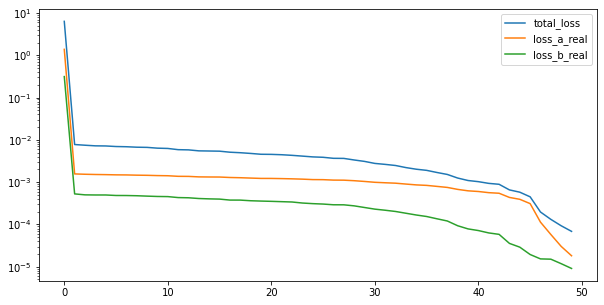

In [21]:
df[['total_loss','loss_a_real','loss_b_real']].plot(figsize=(10,5))
plt.yscale('log')

In [22]:
df[['loss_a_real_0','loss_b_real_0']].std()

loss_a_real_0    0.140483
loss_b_real_0    0.141625
dtype: float32

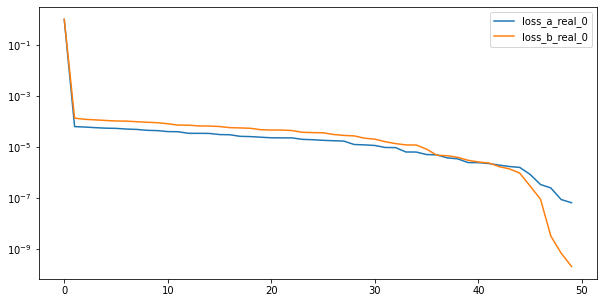

In [23]:
df[['loss_a_real_0','loss_b_real_0']].plot(figsize=(10,5))
plt.yscale('log')

Text(0, 0.5, 'orders of magnitude')

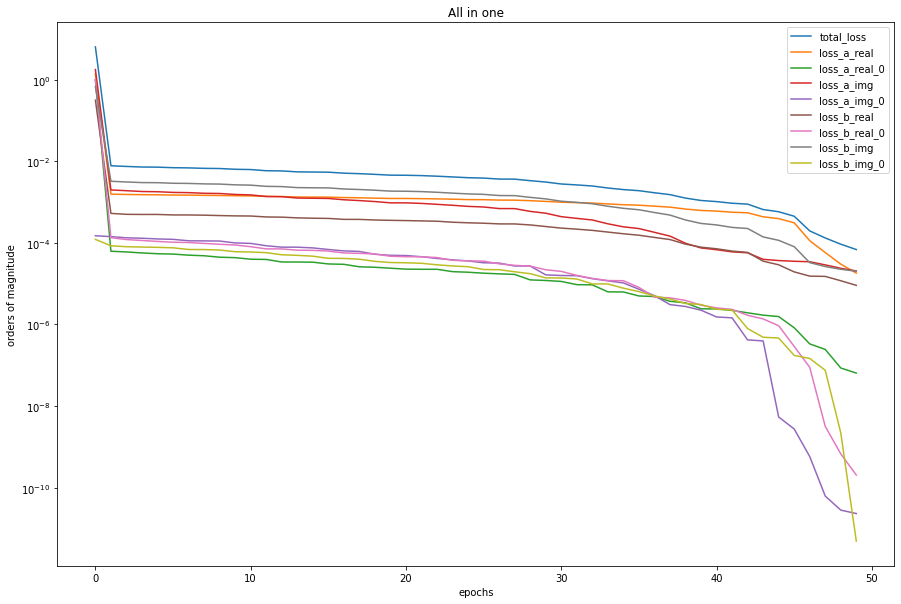

In [24]:
df.plot(figsize=(15,10), title = 'All in one')
plt.yscale('log')
plt.xlabel('epochs')
plt.ylabel('orders of magnitude')

In [25]:
def fun(t,z):
    k = 1.

    z1 = z[0] + z[1]*1.j

    z2 = z[2] + z[3]*1.j

    dz1dt = -k*np.conj(z2)*1.j
    dz2dt = -k*np.conj(z1)*1.j

    dz1dt_real = np.real(dz1dt)
    dz1dt_imag = np.imag(dz1dt)

    dz2dt_real = np.real(dz2dt)
    dz2dt_imag = np.imag(dz2dt)

    return np.array([dz1dt_real,dz1dt_imag,dz2dt_real,dz2dt_imag])

# Interval of integration

t0,tf = t[0],t[-1]
tspan = np.array([t0,tf])
z0 = np.array([1.,0.,1.,0.]) 
teval = t.numpy().reshape(-1)


sol_dic = solve_ivp(fun,   t_span=tspan, y0=z0,t_eval=teval) #default is rk45
assert sol_dic.success == True

sol = sol_dic.y.T   #make it such that solutions are columns not rows


z1_real,z1_img,z2_real,z2_img = sol[:,0],sol[:,1],sol[:,2],sol[:,3]

In [26]:
sol_dic.y.T.shape, ANN_solution.numpy().shape

((2000, 4), (2000, 4))

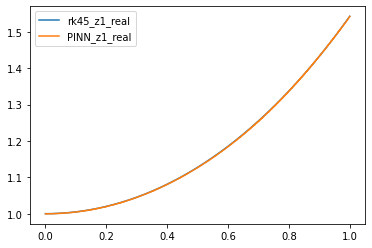

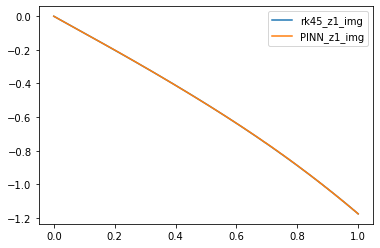

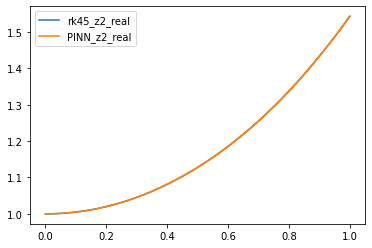

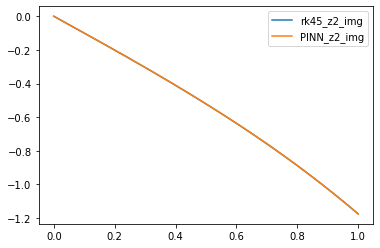

In [27]:
plt.plot(sol_dic.t,z1_real,label = 'rk45_z1_real' )
plt.plot(sol_dic.t,ANN_solution.numpy()[:,0],label = 'PINN_z1_real' )
plt.legend()
plt.show()

plt.plot(sol_dic.t,z1_img,label = 'rk45_z1_img' )
plt.plot(sol_dic.t,ANN_solution.numpy()[:,1],label = 'PINN_z1_img' )
plt.legend()
plt.show()

plt.plot(sol_dic.t,z2_real,label = 'rk45_z2_real' )
plt.plot(sol_dic.t,ANN_solution.numpy()[:,2],label = 'PINN_z2_real' )
plt.legend()
plt.show()

plt.plot(sol_dic.t,z2_img,label = 'rk45_z2_img' )
plt.plot(sol_dic.t,ANN_solution.numpy()[:,3],label = 'PINN_z2_img' )
plt.legend()
plt.show()